# Medium project 
Vincent Ortland, Sonu Rauniyar, Johann Seltmann

This project is based on some questions about the entailments notebook, but also more general ones.

In [1]:
import configparser
import os
import random
from textwrap import fill
import sys
from copy import deepcopy
import pandas as pd
import numpy as np
import nltk
import math
import re
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from visual_genome import api as vg
from PIL import Image as PIL_Image
import requests
from io import StringIO, BytesIO
from scipy.spatial.distance import cosine
import nltk
import math
import matplotlib.pyplot as plt; plt.rcdefaults()

config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config' + \
    ' file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')


sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, query_by_id
from utils import plot_img_cropped, plot_img_ax, invert_dict, get_a_by_b
sys.path.append(dsgv_home + '/WACs/WAC_Utils')
from wac_utils import create_word2den, is_relational
sys.path.append(dsgv_home + '/Preproc')
from sim_preproc import load_imsim, n_most_sim

sys.path.append('/Users/das/work/svn/Gits/p_Public/sempix/Common')
from data_utils import load_dfs, plot_rel_by_relid, get_obj_bb, compute_distance_objs
from data_utils import get_obj_key, compute_relpos_relargs_row, get_all_predicate
from data_utils import compute_distance_relargs_row, get_rel_type, get_rel_instances
from data_utils import compute_obj_sizes_row

In [2]:
df_names = [#'saiapr_bbdf' 
            'saiapr_refdf',
            #'mscoco_bbdf'
            'refcoco_refdf',
            #'refcocoplus_refdf' 
            #'grex_refdf'
            #'vgregdf'
            #'vgimgdf' 
            #'vgobjdf' 
            #'vgreldf'
            #'vgpardf' 
            'cococapdf'
            #'flickr_bbdf'
            #'flickr_capdf'
            #'flickr_objdf'
           ]
df = load_dfs(preproc_path, df_names)

coco_sem_sim, coco_sem_map = load_imsim(os.path.join(preproc_path, 'mscoco_sim.npz'))
coco_id2semsim = invert_dict(coco_sem_map)
coco_vis_sim, coco_vis_map = load_imsim(os.path.join(preproc_path, 'mscoco_vis_sim.npz'))
coco_id2vissim = invert_dict(coco_vis_map)

## Negative Hypotheses from similar contexts

One problem that occured, when choosing negative hypotheses for caption entailment, was that using captions from similar pictures can result in the negative hypothesis being to close to the premise to actually be a negative hypothesis.

Below, we copied the code from the entailment notebook, that chooses hypotheses according to semantic similarity:


In [3]:
# pairing premise and hypotheses
n = 10 # how many to do
tuples = []

this_df = df['cococapdf']
ic = icorpus_code['mscoco']

for _ in range(n):
    # seed image
    ii = np.random.choice(list(coco_id2semsim.keys()))
    premise, phyp =  np.random.choice(query_by_id(this_df, (ic, ii), 'caption'), 2, replace=False)

    # negative hypothesis
    sim_ids = n_most_sim(coco_sem_sim, coco_sem_map, coco_id2semsim[ii], n=5)
    n_ii = np.random.choice(sim_ids[1:])
    nhyp = this_df[this_df['image_id'] == n_ii]['caption'].values[0]
    
    tuples.append((premise, phyp, nhyp))

# colnames = 'premise p-hyp n-hyp'.split()
# pd.DataFrame(tuples, columns=colnames)

for prem, phyp, nhyp in tuples:
    print("-" * 40)
    print("premise: ", prem)
    print("p-hyp:   ", phyp)
    print("n-hyp:   ", nhyp)

----------------------------------------
premise:  A group of air force jets flying information.
p-hyp:    Four aircraft planes flying in the blue sky.
n-hyp:    Several big planes in a huge room with model planes hanging from the ceiling. 
----------------------------------------
premise:  Group of people holding a demonstration in front of a crowd. 
p-hyp:    a person standing in front of a class 
n-hyp:    A man sitting in a blue seat watching a video. 
----------------------------------------
premise:  A man and a woman preparing food in a kitchen.
p-hyp:    a couple of people are cooking at a table
n-hyp:    A woman standing in front of an open microwave oven.
----------------------------------------
premise:  A man is cutting another man's hair next to a window.
p-hyp:    A man sits at a barber shop while the barber cuts his hair
n-hyp:    The people look up at the big screens.
----------------------------------------
premise:  A woman in equestrian wear attaches a bridle to a ho

One simplistic way to reduce the closeness of the hypotheses might be to not choose the five most similar images as references, but to skip them and use images later in the list - the idea being that these images might still be close enough to be a challenge, but not too similar.

In [4]:
#semantic similarity
n = 10 # how many to do
tuples = []

this_df = df['cococapdf']
ic = icorpus_code['mscoco']

for _ in range(n):
    # seed image
    ii = np.random.choice(list(coco_id2semsim.keys()))
    premise, phyp =  np.random.choice(query_by_id(this_df, (ic, ii), 'caption'), 2, replace=False)

    # negative hypothesis
    sim_ids = n_most_sim(coco_sem_sim, coco_sem_map, coco_id2semsim[ii], n=20)
    sim_ids = sim_ids[15:]
    n_index = np.random.choice(len(sim_ids))
    n_ii = sim_ids[n_index]
    nhyp = this_df[this_df['image_id'] == n_ii]['caption'].values[0]
    
    tuples.append((premise, phyp, nhyp, n_index))

# colnames = 'premise p-hyp n-hyp'.split()
# pd.DataFrame(tuples, columns=colnames)

for prem, phyp, nhyp, n_index in tuples:
    print("-" * 40)
    #print(n_index)
    print("premise: ", prem)
    print("p-hyp:   ", phyp)
    print("n-hyp:   ", nhyp)

----------------------------------------
premise:  A woman standing in a room with a cake and some people.
p-hyp:    A woman holding a cake in front of a few other people
n-hyp:    Two naval officers use a ceremonial sword to cut a cake.
----------------------------------------
premise:  There are two dogs outside looking at each other.
p-hyp:    Two dogs interacting at an open air produce market.
n-hyp:    Two men standing next o each other in a busy area.
----------------------------------------
premise:  A cat that is sitting next to some luggage.
p-hyp:    a close up of two luggage bags near one another 
n-hyp:    Several types of luggage are for sale on the shelves.
----------------------------------------
premise:  a bunch of sheep that are eating something off the ground
p-hyp:    A small herd of sheep are standing in the corner of the pen.
n-hyp:    A couple of white baby sheep walking across a field.
----------------------------------------
premise:  many policemen in uniform 

However, this is not very effective. On the one hand some of the hypotheses are further removed from the originals. On the other hand, for some cases where there are many very similar images (e.g. images showing animals or baseball players), the hypotheses are sometimes still too close.

An example for that are captions relating to zebras, as given below:

In [6]:
#semantic similarity, not dropping any zebras
def get_word_indices(this_df, word):
    word_ids = set()
    for ii in coco_id2semsim.keys():
        expr = 'image_id == {}'
        expr = expr.format(ii)
        row = this_df.query(expr)
        caps = row.caption
        for cap in caps:
            found = re.search(word, cap)
            if found:
                word_ids.add(ii)
    return word_ids

n = 10 # how many to do
tuples = []

this_df = df['cococapdf']
ic = icorpus_code['mscoco']
zebra_indices = list(get_word_indices(this_df, "zebra"))

i = 0
while i < n:
    # seed image
    #ii = get_word_index(this_df, "zebra")
    ii = np.random.choice(zebra_indices)
    premise, phyp =  np.random.choice(query_by_id(this_df, (ic, ii), 'caption'), 2, replace=False)

    # negative hypothesis
    sim_ids = n_most_sim(coco_sem_sim, coco_sem_map, coco_id2semsim[ii], n=6)#5)
    if len(sim_ids) < 3:
        continue
        
    #n_ii = list(drop_ids)[0]
    sim_ids = sim_ids[2:]
    #while n_ii in drop_ids:
    n_index = np.random.choice(len(sim_ids))
    n_ii = sim_ids[n_index]
    
    nhyp = this_df[this_df['image_id'] == n_ii]['caption'].values[0]
    
    tuples.append((premise, phyp, nhyp, n_index))
    i += 1


for prem, phyp, nhyp, n_index in tuples:
    print("-" * 40)
    #print(n_index)
    print("premise: ", prem)
    print("p-hyp:   ", phyp)
    print("n-hyp:   ", nhyp)

----------------------------------------
premise:  A herd of zebra walking along a grass covered field.
p-hyp:    Large group of animals walking around a grassy field. 
n-hyp:    A large group of cows on a field.
----------------------------------------
premise:  A couple of zebra standing on top of a field.
p-hyp:    Two zebras standing behind a wire fence next to each other
n-hyp:    Adult and juvenile zebras in an exhibit enclosure.
----------------------------------------
premise:  Two giraffes are in the foreground and there is a zebra in the background.
p-hyp:    A group of giraffe walking across a dirt road.
n-hyp:    a couple of giraffes stand in front of a zebra 
----------------------------------------
premise:  A zebra watches for danger as the rest of the herd relaxes.
p-hyp:    A large herd of zebra standing on short grass. 
n-hyp:    Adult and juvenile zebras in an exhibit enclosure.
----------------------------------------
premise:  An adult and young zebra graze in a fi

In order to tackle this particular problem, we dropped a percentage of rows containing the word "zebra" from the dataframe.

In [7]:
def drop_by_word(this_df, word, drop_fraction=0.1):
    found_ids = set()
    for row in this_df.iterrows():
        cap = row[1].caption
        this_id = row[1].image_id
        found = re.search(word, cap)
        if found:
            found_ids.add(this_id)
    drop_ids = set()
    for _ in range(int(len(found_ids) * drop_fraction)):
        to_drop = random.sample(found_ids, 1)[0]
        drop_ids.add(to_drop)
        found_ids.remove(to_drop)
    for drop_id in drop_ids:
        this_df = this_df[this_df.image_id != drop_id]
    print("number of dropped rows:", 
          len(drop_ids))
    return this_df, drop_ids

this_df = df['cococapdf']
drop_zebra_df, drop_ids = drop_by_word(this_df, 
                                       r"[Zz]ebra", 
                                       drop_fraction=0.75)

number of dropped rows: 1056


We can then repeat the drawing of hypotheses. However, it does not seem to produce much better results:

In [8]:
#semantic similarity, dropping 75% of zebras
n = 10 # how many to do
tuples = []

this_df = drop_zebra_df
ic = icorpus_code['mscoco']

zebra_indices = list(get_word_indices(this_df, r"[Zz]ebra"))

i = 0
while i < n:
    ii = np.random.choice(zebra_indices)
    premise, phyp =  np.random.choice(query_by_id(this_df, (ic, ii), 'caption'), 2, replace=False)

    # negative hypothesis
    sim_ids = n_most_sim(coco_sem_sim, coco_sem_map, coco_id2semsim[ii], n=6)#5)
    if len(sim_ids) < 3:
        continue
    sim_ids = sim_ids[2:]#ignore closest images
    n_ii = list(drop_ids)[0]
    while n_ii in drop_ids:
        n_index = np.random.choice(len(sim_ids))
        n_ii = sim_ids[n_index]
        sim_ids.remove(n_ii)
        if sim_ids == []:
            break
    if n_ii in drop_ids:
        continue
    
    nhyp = this_df[this_df['image_id'] == n_ii]['caption'].values[0]
    
    tuples.append((premise, phyp, nhyp, n_index))
    i += 1

for prem, phyp, nhyp, n_index in tuples:
    print("-" * 40)
    print("premise: ", prem)
    print("p-hyp:   ", phyp)
    print("n-hyp:   ", nhyp)

----------------------------------------
premise:  Two zebras are pictured in a barren area.
p-hyp:    A couple of zebra standing on top of a dirt field.
n-hyp:    Three zebras by a wooded area eating grass. 
----------------------------------------
premise:  Several zebras grazing in a very green area
p-hyp:    some zebras eating some green grass and trees
n-hyp:    A group of zebras are near the side of the road, with one on its back. 
----------------------------------------
premise:  A zebra and its child standing in a grassy field under the shade of a tree
p-hyp:    a baby zebra is standing next to its mom
n-hyp:    A group of zebras are near the side of the road, with one on its back. 
----------------------------------------
premise:  Two zebra walk together on the short grass.
p-hyp:    These zebra are walking side by side on green grass.
n-hyp:    A group of zebras are near the side of the road, with one on its back. 
----------------------------------------
premise:  Two gira

We then considered a third way of getting more sensible negative hypotheses. The idea is that we can draw image_ids of similar images from both the list based on visual similarity and the list based on semantic similarity. We then only use image_ids that appear in one, but not the other of the two lists, in the hope that this will rule out very similar images. This seems to be working to some degree, especially if combined with the first approach.

In [9]:
#combination from sem_sim and vis_sim
n = 10 # how many to do
tuples = []

this_df = df['cococapdf']
ic = icorpus_code['mscoco']

for _ in range(n):
    # seed image
    ii = np.random.choice(list(coco_id2vissim.keys()))
    premise, phyp =  np.random.choice(query_by_id(this_df, (ic, ii), 'caption'), 2, replace=False)

    # negative hypothesis
    vis_sim_ids = n_most_sim(coco_vis_sim, coco_vis_map, coco_id2vissim[ii], n=50)[10:]
    sem_sim_ids = n_most_sim(coco_sem_sim, coco_sem_map, coco_id2semsim[ii], n=50)[10:]
    
    sim_ids = [ii for ii in sem_sim_ids + vis_sim_ids
              if ii not in sem_sim_ids or ii not in vis_sim_ids]

    if sim_ids == []:
        continue
    sim_ids = list(set(sim_ids))
    if ii in sim_ids:
        sim_ids.remove(ii)
    n_ii = np.random.choice(sim_ids)
    nhyp = this_df[this_df['image_id'] == n_ii]['caption'].values[0]
    
    tuples.append((premise, phyp, nhyp))

for prem, phyp, nhyp in tuples:
    print("-" * 40)
    print("premise: ", prem)
    print("p-hyp:   ", phyp)
    print("n-hyp:   ", nhyp)

----------------------------------------
premise:  a man playing tennis gets ready to serve his opponent
p-hyp:    People are watching others play a game of tennis.
n-hyp:    man playing base ball with others looking on 
----------------------------------------
premise:  A view of two beds and a mirror in between.
p-hyp:    A hotel room with two queen beds and white bedding.
n-hyp:    A hotel room with two bed that have been made already.
----------------------------------------
premise:  Two zebra walking next to each other on a stone covered field.
p-hyp:    Two zebras stand in a field with rocks together.
n-hyp:    A couple of zebra standing on top of a lush greenfield.
----------------------------------------
premise:  A calf is standing on some straw while looking straight out at the camera.
p-hyp:    Two baby cows standing next to each other on dry grass.
n-hyp:    Cattle standing in grassy field with more lying on ground in background.
----------------------------------------
pr

However, it is hard to tell definitively if these approaches are useful since we lack a clear metric of telling the similarity of the hypotheses.

Another reason for very closes hypotheses (which we didn't tackle), was that some captions are somewhat unspecific and thus can apply to different situations (something like: "Three zebras in a grassy field" vs. "A group of zebras").

## Similarity of word representations

The entailment notebook describes a way to generate word representations from the contexts in which these word appear by using the regions of images as context. It points out that this differs from approaches that generate word representations using linguistic context because words that usually appear in similar contexts but actually have differing meaning.

In order to investigate this difference a bit further we used pre-trained word2vec vectors from \cite{dinubaroni} to measure distances between words in the contexts given by the images.

In [5]:
coco_ref_corps = ["refcoco_refdf"]

def get_all_refexps(corps, id_triple, tagged=False):
    this_refexp = []
    for this_corp in coco_ref_corps:
        if not tagged:
            this_refexp.extend(query_by_id(df[this_corp], id_triple, column='refexp'))
        else:
            this_refexp.extend(query_by_id(df[this_corp], id_triple, column='tagged'))
    return this_refexp


def read_w2v_vectors(words, w2v_filename):
    #http://marcobaroni.org/composes/semantic-vectors.html
    vector_dict = dict()
    with open(w2v_filename) as w2v_file:
        for line in w2v_file:
            line = line[:-1]
            entries = line.split("\t")
            if entries[0] in words:
                numbers = [float(x) for x in entries[1:]]
                vec = np.array(numbers)
                vector_dict[entries[0]] = vec
    return vector_dict

def get_word_dist(w1, w2, vector_dict):
    if not w1 in vector_dict or not w2 in vector_dict:
        return None
    vec1 = vector_dict[w1]
    vec2 = vector_dict[w2]

    dist = cosine(vec1, vec2)

    return dist


def basic_distance_avg(ref_exps, vector_dict, count_words=False):
    context_dists = []
    distr_dists = []

    context_lengths = []
    distr_lengths = []

    for target_word, context_words, distr_words in ref_exps:
        def get_dist(x):
            return get_word_dist(target_word, x, vector_dict)

        context_dists = list(filter(lambda x: x is not None,
                             map(get_dist, context_words)))
        context_lengths.append(len(context_dists))
        if len(context_dists) == 0:
            continue
        context_avg = np.mean(context_dists)

        distr_dists = list(filter(lambda x: x is not None,
                                  map(get_dist, distr_words)))
        distr_lengths.append(len(distr_dists))
        if len(distr_dists) == 0:
            continue
        distr_avg = np.mean(distr_dists)

        context_dists.append(context_avg)
        distr_dists.append(distr_avg)

    context_avg = np.mean(context_dists)
    distr_avg = np.mean(distr_dists)
    context_dev = np.std(context_dists)
    distr_dev = np.std(distr_dists)

    print("avg distance to words in same context:", context_avg)
    print("std. dev.:", context_dev)
    print("avg distance to words in different context:", distr_avg)
    print("std. dev.:", distr_dev)

    if count_words:
        con_len_avg = np.mean(context_lengths)
        con_len_dev = np.std(context_lengths)
        distr_len_avg = np.mean(distr_lengths)
        distr_len_dev = np.std(distr_lengths)

        print("avg number of context words:", con_len_avg)
        print("std dev:", con_len_dev)
        print("avg number of distractor words:", distr_len_avg)
        print("std dev:", distr_len_dev)

As a first step, we used the code from the entailments notebook to draw 10000 contexts and distractor words from different contexts. For each of the contexts, we calculated the average distance to words in the same context and the average distance to the distractor words, according to word2vec. In the general case there doesn't seem to be a big difference, although this can change slightly depending on which contexts are drawn.

In [14]:
def get_ref_words():
    all_words = set()
    ref_exps = []

    for _ in range(10000):
        target = df['refcoco_refdf'].sample()
        target_triple = target[['i_corpus', 'image_id', 'region_id']].values[0]

        target_refexps = get_all_refexps(coco_ref_corps, target_triple)
        distr_refexps = df['refcoco_refdf'].sample(5)['refexp'].tolist()

        context_words = list(set(' '.join(target_refexps).split()))
        distr_words = list(set(' '.join(distr_refexps).split()))

        all_words.update(context_words)
        all_words.update(distr_words)

        poss_target_words = list(filter(lambda x: len(x)>=5, context_words))
        if poss_target_words == []:
            poss_target_words = context_words
        target_word = np.random.choice(poss_target_words)
        context_words.remove(target_word)

        ref_exps.append((target_word, context_words, distr_words))

    return all_words, ref_exps

all_words, ref_exps = get_ref_words()
vector_dict = read_w2v_vectors(all_words,
                    "/home/johann/DS_Generation/EN-wform.w.5.cbow.neg10.400.subsmpl.txt")
basic_distance_avg(ref_exps, vector_dict)

avg distance to words in same context: 0.9231640588499527
std. dev.: 0.022266570610562825
avg distance to words in different context: 0.9172634559655612
std. dev.: 0.07221662247872816


In order to get a clearer picture of the effect, we split looked at the distances according to the POS-tags of the words. This didn't lead to useful results for all parts of speech, because there are not usually enough words in each of the annotations to contain many words with the same POS. Interestingly, nouns that occur in the same context, seem to be closer to each other according to word2vec than to nouns in different contexts. However, this should be taken with a grain of salt, again because of the small numbers in each annotation and it might also change, depending on the random samples. An analysis of all the data might therefore yield different results. 

In [9]:
def get_ref_words_tag(POS_tags, df):
    all_words = set()
    ref_exps = []

    for _ in range(10000):
        context_words = []
        target = df.sample()
        target_triple = target[['i_corpus', 'image_id', 'region_id']].values[0]
        target_refexps = get_all_refexps(coco_ref_corps, target_triple,
                                        tagged=True)
        context_words = [x for l in target_refexps for x in l]

        distr_refexps = df.sample(5)['tagged'].tolist()
        distr_words = [x for l in distr_refexps for x in l]

        poss_target_words = [x for x in context_words
                             if len(x[0]) >= 5 and x[1] in POS_tags]
        if poss_target_words == []:
            poss_target_words = context_words
        target_word_ind = np.random.choice(range(len(poss_target_words)))
        target_word, target_pos = poss_target_words[target_word_ind]
        context_words.remove([target_word, target_pos])

        #remove any word with different POS tag
        #(also, remove the POS tags)
        context_words = [w[0] for w in context_words if w[1] in POS_tags]
        distr_words = [w[0] for w in distr_words if w[1] in POS_tags]

        all_words.update([x for x in context_words])
        all_words.update([x for x in distr_words])

        ref_exps.append((target_word, context_words, distr_words))

    return all_words, ref_exps

In [10]:
####pos
#JJ,JJR,JJS (adjectives)
adj_words, adj_exps = get_ref_words_tag(["JJ","JJR","JJS"], df["refcoco_refdf"])
#NN,NNS,NNP,NNPS (nouns)
noun_words, noun_exps = get_ref_words_tag(["NN","NNS","NNP","NNPS"], df["refcoco_refdf"])
#VB,VBD,VBG,VBP,VBN,VBZ (verbs)
verb_words, verb_exps = get_ref_words_tag(["VB","VBD","VBG","VBP","VBN","VBZ"], df["refcoco_refdf"])
#PRP,PRP$,WP,WP$ (pronouns)
pro_words, pro_exps = get_ref_words_tag(["PRP","PRP$","WP","WP$"], df["refcoco_refdf"])

##this syntax surprisingly unites sets
all_words = adj_words | noun_words | verb_words | pro_words

vector_dict = read_w2v_vectors(all_words,
                    "/home/johann/DS_Generation/EN-wform.w.5.cbow.neg10.400.subsmpl.txt")
print("nouns:")
basic_distance_avg(noun_exps, vector_dict)

print("\n\nadjectives:")
basic_distance_avg(adj_exps, vector_dict)
        
print("\n\nverbs:")
basic_distance_avg(verb_exps, vector_dict)

print("\n\npronouns:")
basic_distance_avg(pro_exps, vector_dict)

nouns:
avg distance to words in same context: 0.28745687882599585
std. dev.: 0.35206133808837187
avg distance to words in different context: 0.9558600059518257
std. dev.: 0.028276036166177482


adjectives:
avg distance to words in same context: nan
std. dev.: nan
avg distance to words in different context: nan
std. dev.: nan


verbs:
avg distance to words in same context: nan
std. dev.: nan
avg distance to words in different context: nan
std. dev.: nan


pronouns:
avg distance to words in same context: 0.8256623366116889
std. dev.: 0.0
avg distance to words in different context: 0.8714156287548632
std. dev.: 0.0


### Reference

[1] M. Baroni, G. Dinu and G. Kruszewski. 2014. Don't count, predict! A systematic comparison of context-counting vs. context-predicting semantic vectors Proceedings of ACL 2014 (52nd Annual Meeting of the Association for Computational Linguistics), East Stroudsburg PA: ACL, 238-247.


## Sense homonym ambiguation & POS-tag 

We tried to find out whether the datasets could be used to deal with homonyms.
For this pupose we selected ```saiapr_refdf``` dataframe to work on the concept. Among its 7 columns we performed analysis on the ```tagged column``` to see whether same word has different tags parsing all the sentences. Additionally, the goal was also to check if the words which are not the true homonyms as referred to  [List_of_true_homonyms](https://en.wikipedia.org/wiki/List_of_true_homonyms) exists. 

### Result

Based on the POS-tagging provided it turns out that around 0.39% (```1615``` out of ```411919```) of the words in the selected corpus are homonyms. It is assumed auto POS-tagging was used where the tagging seems relatively poor.Most of the phrase/sentences are not complete & gramatically seems incorrect which makes the POS-tagging dfficult. For an instance the below phrases used in the different context explain better:

- `right most seal` seems better to have `'NN'` tag but its tagged as `'JJ'`.
-  `sky upper left` tagged as `sky, 'JJ'` while `upper` is tagged  `'NN'`

`forward slash` `"/"` taggings:

- '/' : taggesd with {'CD', 'VBN', 'NNP', 'VBZ', 'JJ', 'VBP', 'NN', 'NNS'},

`letters` are tagged for an instance: 

- 'l': tagged with {'JJ', 'NN'},


Most of the them are not true homonyms. For an instance word `building` `(not a true Homonyms)` has tags:


- verb ('VBG') used in the context `first building starting on left` *seems worngly tagged*
- noun ('NN')  used in the context ` white building to the left ` 

Similarly, word `fat` `(true homonym)` has below tags:

- Verb ('VB'), in the context `middle fat one` *seems wrongly tagged*. Though `fat` as homonym has verb meaning as well	 
- Adjectives ('JJ'), in the context `fat man looking at camera bottom` 
- Noun ('NN'), in the context `banana left of short fat chik`. Though `fat` as a homonym has noun meaning as well.


one of the maximum number of tags is for the homonym `left` with ***15 tags***:

- left': {'FW', 'CD', 'RBR', 'VBN', 'VBD','VB', 'VBZ', 'RB', 'JJ', 'SYM', 'NN', 'NNS', 'JJS', 'JJR', [$] }

one of the minimum number of tags is for the homonym ` stool` ***2 tags***:

- stool': {'JJ', 'NN'}

***Conclusion***: Homonyms were seen in the corpus but most of them seems to have been mistakly POS-tagged.

In [17]:
df_analyse = df['saiapr_refdf']
list = df_analyse[['tagged']].values.tolist()


df_analyse['number_of_words'] = df_analyse.refexp.apply(lambda x: len(x.split()))


Total = df_analyse['number_of_words'].sum()

In [18]:
my_dict = dict()

for s in list:
    for sentence in s:
        for word, tag in sentence:
            if tag not in my_dict:
                my_dict[tag] = [word]                
            else:
                my_dict[tag].append(word)


flipped = {}
 
for key, value in my_dict.items(): 
    value=tuple(value)
    for k in value:
        if k not in flipped:
            flipped[k] = [key] 
        else:
            flipped[k].append(key) 
            
            
for key in flipped:
    value = flipped[key]
    value = set(value)
    flipped[key] = value

# final dict with words having more than one tag only were considered
di = {k:v for k,v in flipped.items() if len(v) != 1} 

max_key = max(di, key=lambda k: di[k])
min_key = min(di, key=lambda k: di[k])

print("===========================================================================================")
print("Total number of words used as Homonyms",len(di.keys()))
print ("Total words in the corpus",Total)
print("15 tags for the word:",max_key)
print("2 tags for the word:",min_key)
print("===========================================================================================")
print("\nWords and rescpective tags: \n\n" ,di)

Total number of words used as Homonyms 1615
Total words in the corpus 411919
15 tags for the word: left
2 tags for the word: stool

Words and rescpective tags: 

 {'sky': {'SYM', 'VBD', 'NN', 'JJ', 'VBN', 'VB', 'VBZ', 'NNS'}, 'seal': {'JJ', 'VB', 'NN'}, 'sand': {'VB', 'VBP', 'NN'}, 'right': {'RB', 'VBD', 'NN', 'JJ', 'VB', 'VBG'}, 'corner': {'RB', 'VBD', 'NN', 'JJR', 'JJ', 'VBZ', 'VB', 'NNS', 'VBP'}, 'dirt': {'JJ', 'VBZ', 'VB', 'NN'}, 'path': {'VB', 'IN', 'NN'}, 'left': {'RB', 'SYM', 'VBD', 'NN', 'CD', 'JJ', 'VBN', 'VB', 'VBZ', 'NNS', 'JJR', 'JJS', 'RBR', '$', 'FW'}, 'tower': {'RP', 'JJR', 'NN', 'JJ', 'VB'}, 'umbrella': {'JJ', 'RP', 'VB', 'NN'}, 'chick': {'JJ', 'VB', 'VBP', 'NN'}, 'building': {'VBG', 'NN'}, 'van': {'JJ', 'VB', 'NNS', 'NN'}, 'boat': {'VB', 'IN', 'NN'}, 'side': {'RB', 'PDT', 'NN', 'JJ', 'VBZ', 'VB', 'VBP'}, 'patch': {'VB', 'VBP', 'NN'}, 'snow': {'RB', 'NN', 'JJ', 'VB', 'NNS', 'VBP'}, 'middle': {'RB', 'PDT', 'VBD', 'CC', 'NNP', 'RBS', 'NN', 'CD', 'JJ', 'VBN', 'VB', 'VBZ', 

## Exploring ambiguous objects in the VisualGenome corpus

The idea is to generate an overview of objects that are often described with ambiguous phrases.
Imagine the Mona Lisa. One person would describe her as smiling where another person may say, she looks sad.

The approach is, to take a look at an object in an image. There can be multiple regions that annotators selected that are overlapping with the object region. Annotators also supplied a phrase for each region describing what's inside. I have assigned a region to an object, if the overlap of their bounding boxes is at least 90%.

Now the ambiguities between all regions to an object are calculated. I used the BLEU-score as the measure to compare the phrases and took the maximum BLEU-score as a measure for the ambiguity between the phrases. If the annotators said very similar sentences about the same object, the score will be high and low otherwise.

The resulting mapping of objects to their ambiguity measure (BLEU-score), is then sorted. The 5000 objects with the highest ambiguity (lowest BLEU-score) are then frequency-counted. So if a object is often seen in a high-ambiguity situation, it will get more counts.

I have visualized these frequencies below. Think of the frequencies as 'How often is an object occuring in a high-ambiguous situation?'

The resulting list roughly resembles the object counts of the corpus. However some terms look promising. For example 'plate'. It can mean the license plate of a car or a plate on the table. But also a steel-plate.

To find out more, I normalized the counts with the frequencies of the objects in the corpus.
This resulted in another list that displays more uncommon words. Interestingly animals are common in the top 30.

Another interesting thing to look at, would be to find out high-ambiguous relations and attributes. However due to time limitations, this has to be done in future work.

In [13]:
import json as js

#attr_synsets = js.load(open('/mnt/hdd/data/visual_genome/attribute_synsets.json', 'r'))
#attributes = js.load(open('/mnt/hdd/data/visual_genome/attributes.json', 'r'))
#image_data = js.load(open('/mnt/hdd/data/visual_genome/image_data.json', 'r'))
objects = js.load(open('/mnt/hdd/data/visual_genome/objects.json', 'r'))
object_synsets = js.load(open('/mnt/hdd/data/visual_genome/object_synsets.json', 'r'))
#question_answers = js.load(open('/mnt/hdd/data/visual_genome/question_answers.json', 'r'))
region_descriptions = js.load(open('/mnt/hdd/data/visual_genome/region_descriptions.json', 'r'))
#relationships = js.load(open('/mnt/hdd/data/visual_genome/relationships.json', 'r'))
#relationship_synsets = js.load(open('/mnt/hdd/data/visual_genome/relationship_synsets.json', 'r'))
#scene_graphs = js.load(open('/mnt/hdd/data/visual_genome/scene_graphs.json', 'r'))

In [3]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    bb1['x1'] = bb1['x']
    bb1['y1'] = bb1['y']
    bb1['x2'] = bb1['x'] + bb1['width']
    bb1['y2'] = bb1['y'] + bb1['height']
    
    bb2['x1'] = bb2['x']
    bb2['y1'] = bb2['y']
    bb2['x2'] = bb2['x'] + bb2['width']
    bb2['y2'] = bb2['y'] + bb2['height']
    
    try:
        assert bb1['x1'] < bb1['x2']
        assert bb1['y1'] < bb1['y2']
        assert bb2['x1'] < bb2['x2']
        assert bb2['y1'] < bb2['y2']
    except AssertionError:
        return 0.

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [18]:
from nltk.translate.bleu_score import sentence_bleu
from nltk import word_tokenize
from collections import Counter

def score_bleu(objs, descs):
    """
        Calculate a dictionary of objects in the image to the maximum bleu score of regions overlapping with it.
    """
    # first create a dictionary with all objects in the image that are overlapped by multiple regions.
    # for example if there is a mug in the picture, two annotators could have given two regions,
    # the first one saying 'brown coffee mug' and the second 'dark tea mug'
    # the dictionary maps from the object_id to a set of region_ids
    d = dict()
    for r1 in descs['regions']:
        r1_objs = []
        for o in objs['objects']:
            o['width'] = o['w']
            o['height'] = o['h']
            if get_iou(r1, o) >= .9:
                r1_objs.append(o)
            
        if len(r1_objs) == 1:
            r1_regions = set()
            for r2 in descs['regions']:
                if r1 != r2 and get_iou(r1, r2) >= .9:
                    #print(r1['phrase'])
                    #print(r2['phrase'])
                    #print('...' * 40)
                    r1_regions.add( r2['region_id'] )
            
            if len(r1_regions) > 2:
                for obj in r1_objs:
                    oid = obj['object_id']
                    if oid not in d:
                        d[oid] = set()
                    regs = d[oid]
                    regs.update(r1_regions)
                    d[oid] = regs
                   
    # now calculate the BLEU-scores for every region_phrase for every object from the last dictionary.
    # the list of BLEU-scores is then minimized to the largest BLEU-score that could be found.
    # the idea is, that the BLEU-score form a measure for the agreement of the prases of the regions 
    # describing the same object. If a lot of annotators said similar things about this object, the BLEU-score 
    # is going to be high. If not, the BLEU-score is going to be low.
    d_bleu = dict()
    for oid in d.keys():
        regions = d[oid]
        bleus = []
        for rid in regions:
            my_ref = None
            refs = []
            for r in descs['regions']:
                if r['region_id'] in (regions - {rid}):
                    refs.append(word_tokenize(r['phrase']))
                    
                if r['region_id'] == rid:
                    my_ref = word_tokenize(r['phrase'])
                    
            if my_ref != None and len(refs) > 0:
                bleus.append(sentence_bleu(refs, my_ref))
        if len(bleus) > 0:
            d_bleu[oid] = max(bleus)
    return d_bleu
      
# calculate BLEU-score dictionary for all images
d = dict()
for i in range(len(objects)):
    if i%10000 == 0:
        print(i, '/', len(objects))
    d.update(score_bleu(objects[i], region_descriptions[i]))
    
d_list = [(k, v) for k, v in d.items()]

d_list.sort(key=lambda x: x[1])

# cut off non-ambiguous objects and count the occurrences of the names of the objects in a list
oid_to_obj = dict()
for odat in objects:
        for o in odat['objects']:
            oid_to_obj[o['object_id']] = o
            
tmp = []
for i, (oid, bleu) in enumerate(d_list[:5000]):
    obj = oid_to_obj[oid]
    for name in obj['names']:
        tmp.append(name)
        
cnt = Counter(tmp)

cnt.most_common(100)

0 / 108077


/home/himbiss/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/himbiss/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/home/himbiss/anaconda3/lib/python3.6/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


10000 / 108077
20000 / 108077
30000 / 108077
40000 / 108077
50000 / 108077
60000 / 108077
70000 / 108077
80000 / 108077
90000 / 108077
100000 / 108077


[('man', 418),
 ('woman', 184),
 ('plate', 110),
 ('cat', 110),
 ('bus', 94),
 ('dog', 93),
 ('boy', 92),
 ('girl', 90),
 ('person', 76),
 ('sign', 76),
 ('giraffe', 65),
 ('bear', 64),
 ('car', 61),
 ('pizza', 56),
 ('water', 53),
 ('table', 51),
 ('train', 45),
 ('chair', 42),
 ('bowl', 40),
 ('airplane', 39),
 ('bench', 39),
 ('sky', 37),
 ('zebra', 37),
 ('elephant', 36),
 ('bird', 35),
 ('guy', 35),
 ('building', 35),
 ('clock', 33),
 ('cow', 32),
 ('lady', 31),
 ('laptop', 31),
 ('glass', 31),
 ('horse', 30),
 ('fence', 27),
 ('shirt', 26),
 ('fire hydrant', 24),
 ('truck', 24),
 ('cake', 24),
 ('couch', 23),
 ('child', 22),
 ('people', 22),
 ('animal', 22),
 ('tree', 22),
 ('mirror', 21),
 ('computer', 21),
 ('plane', 21),
 ('player', 20),
 ('box', 19),
 ('grass', 19),
 ('wall', 18),
 ('paper', 18),
 ('baseball player', 18),
 ('motorcycle', 18),
 ('board', 18),
 ('umbrella', 18),
 ('cup', 18),
 ('picture', 17),
 ('boat', 17),
 ('bike', 17),
 ('bag', 17),
 ('field', 16),
 ('toile

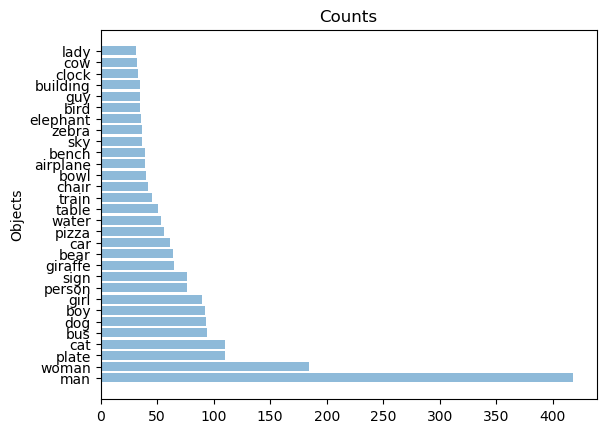

In [19]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

common = cnt.most_common(30)
objs = [n for n, c in common]
y_pos = np.arange(len(objs))
performance = [c for n, c in common]

plt.barh(y_pos, performance, alpha=0.5)
plt.yticks(y_pos, objs)
plt.ylabel('Objects')
plt.title('Counts')

plt.show()

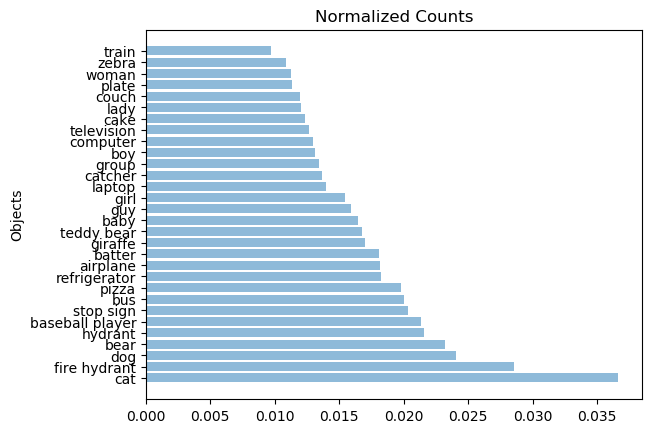

In [43]:
# cut off non-ambiguous objects and count the occurrences of the names of the objects in a list
oid_to_obj = dict()
tmp = []
for odat in objects:
        for o in odat['objects']:
            oid_to_obj[o['object_id']] = o
            for n in o['names']:
                tmp.append(n)

nfreq = Counter(tmp)
    
common = [(n, (c / nfreq[n])) for n, c in cnt.items() if c > 10]
common.sort(key=lambda x: x[1], reverse=True)
common = common[:30]
objs = [n for n, c in common]
y_pos = np.arange(len(objs))
performance = [c for n, c in common]

plt.barh(y_pos, performance, alpha=0.5)
plt.yticks(y_pos, objs)
plt.ylabel('Objects')
plt.title('Normalized Counts')

plt.show()

# References

<mark> <b>The bib file biblio.bib was not found

</b> </mark>(<a id="cit-dinubaroni" href="#call-dinubaroni">?</a>) !! _This reference was not found in biblio.bib _ !!

